In [1]:
import os
from tqdm import tqdm
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

import re
import gensim
from konlpy.tag import Mecab
import sentencepiece as spm

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant

from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline

#### utils 함수

In [10]:
# 텍스트 전처리 함수
def text_prep(x):
    x = re.sub("[^ㄱ-ㅎ가-힣?!,.]+"," ", x)
    x = re.sub("[ ]+"," ", x)
    x = x.strip()
    return x    


# Mecab의 단어 빈도 사전 구축
def bin_dict(tokens):
    dic = defaultdict()
    for data in tokens:
        for word in data:
            if word in dic:
                dic[word] += 1
            else:
                dic[word] = 0

    dic = sorted(dic.items(), key = lambda x: x[1], reverse = True)
    dic = dict(dic)
    return dic


# Mecab의 단어-인덱스, 인덱스-단어 사전 구축
def word_index(dic, vocab_size):
    word_to_index = defaultdict()
    index_to_word = defaultdict()
    
    
    dic = list(dic.items())[:(vocab_size - 2)]
    dic = dict(dic)
    for ind, word in enumerate(dic):
        word_to_index[word] = ind + 2
        index_to_word[ind + 2] = word
    
    word_to_index["<pad>"] = 0
    index_to_word[0] = "<pad>"
    word_to_index["<unk>"] = 1
    index_to_word[1] = "<unk>"

    word_to_index = dict(word_to_index)
    index_to_word = dict(index_to_word)
    return word_to_index, index_to_word


#  Mecab 토큰화 적용
def tokenization(corpus, dictionary):
    tokens = []
    for setence in tqdm(corpus):
        tmp = [dictionary[word] if word in dictionary else 1 for word in setence]
        tokens += [tmp]
    return tokens


# 일반 판다스 데이터프레임을 텐서플로우 데이터셋으로 변환
def tensorflow_dataset(input_x, input_y, buffer_size, batch_size):
    tf_data = tf.data.Dataset.from_tensor_slices((input_x, input_y))
    tf_data = tf_data.shuffle(buffer_size)
    tf_data = tf_data.repeat()
    tf_data = tf_data.batch(batch_size)
    tf_data = tf_data.prefetch(buffer_size = -1)
    return tf_data 


# spm 모델 생성 및 단어장 생성
def SentencePiece(model_type, data, vocab_size, add, train_test, temp_file = None):
    if not temp_file:
        temp_file = f"./model/02_SentencePiece/{model_type}_{vocab_size}_pre{add}_{train_test}.tmp"
    
    with open(temp_file, 'w') as f:
        for row in data["document"]:
            f.write(str(row) + '\n')
    spm_input = f"""
    --input={temp_file} 
    --model_prefix={model_type}_{vocab_size}_spm 
    --vocab_size={vocab_size} 
    --model_type={model_type}
    """
    spm_input = re.sub("\n", "", spm_input)
    spm.SentencePieceTrainer.Train(spm_input)

    s = spm.SentencePieceProcessor()
    s.Load(f'{model_type}_{vocab_size}_spm.model')
    return s


# 학습과정 히스토리 시각화
def show_performance(history, title):
    loss, acc, val_loss, val_acc, lr = history.history.values()
    plt.plot(loss, label = "loss")
    plt.plot(acc, label = "acc")
    plt.plot(val_loss, label = "val_loss")
    plt.plot(val_acc, label = "val_acc")
    plt.title(title)
    plt.xlabel("epochs")
    plt.legend()
    plt.show()


# 사전학습된 임베딩 행렬 불러오기
def load_embedding_matrix(path, vocab_size, embedding_size, idx_word):
    word2vec = gensim.models.Word2Vec.load(path)
    embedding_matrix = np.random.rand(vocab_size, embedding_size)
    count = 0
    # embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
    for i in range(2,vocab_size):
        if idx_word[i] in word2vec:
            embedding_matrix[i] = word2vec[idx_word[i]]
            count += 1
    print(f"사전 학습에 사용 가능했던 단어 벡터 갯수 : {count}")
    return embedding_matrix

## 1. 데이터 파이프라인

데이터 로드  

데이터 전처리
 - 기본 전처리
    - 중복되는 데이터 제거
    - 결측치 데이터 제거  
    
    
  - 추가 전처리
    - 텍스트 특수문자 전처리
    - 이상치 데이터 제거
    - 결측치 데이터 제거
    
데이터 벡터화

    0. 형태소 분석기 (Mecab)  
    1. SentencePiece (Uni-gram)  
    2. SentencePiece (Byte-pair-encoding)
    
텐서플로우 데이터셋 변환    

In [25]:
class DataPipeline():

    
    def __init__(self, path_to_file, train_test):
        self.path_to_file = path_to_file
        self.train_test = train_test
        # 데이터 불러오기
        self.data = pd.read_csv(path_to_file, sep = "\t")
        
        
    # 데이터 전처리 적용
    def preprocessing(self, add = False):
        cp_data = self.data.copy()
        self.add = add
        # 중복 데이터 제거
        cp_data = cp_data.drop_duplicates("document")
        cp_data = cp_data.reset_index()
        
        # 결측 데이터 제거
        cp_data = cp_data.replace(["",'', " ", ' '], np.nan)
        cp_data = cp_data.dropna()
        cp_data["len"] = cp_data["document"].apply(lambda x : len(x))
        if add:
            # 텍스트 전처리 함수 적용
            cp_data["document"] = cp_data["document"].apply(lambda x: text_prep(x))
            
            # IQR 기준 이상치 제거 훈련 데이터셋 적용
            data_Q3 = cp_data.describe().loc["75%", "len"]
            data_Q1 = cp_data.describe().loc["25%", "len"]
            data_IQR = data_Q3 - data_Q1
            data_upper = data_Q3 + data_IQR
            data_lower = data_IQR - data_Q1
            cp_data = cp_data.loc[(cp_data["len"] >= data_lower) & 
                                    (cp_data["len"] <= data_upper), :]            

            # 결측 데이터 제거
            cp_data = cp_data.replace(["",'', " ", ' '], np.nan)
            cp_data = cp_data.dropna()
            
            self.cp_data = cp_data
            return cp_data
        else:
            self.cp_data = cp_data
            return cp_data
        
    
    # 데이터 벡터화 적용 : Mecab, SentencePiece(BPE, Uni-gram)
    def vectorization(self, vec_model, vocab_size):
        
        # Mecab 형태소 분석
        if vec_model == 0: 
            # Mecab으로 형태소 단위로 분절
            mecab = Mecab()
            tqdm.pandas()
            tokens = self.cp_data["document"].progress_apply(lambda x: mecab.morphs(x))
            # 빈도 기반 단어 사전 구축
            num_dict = bin_dict(tokens)
            word_to_index_dict, index_to_word_dict = word_index(num_dict, vocab_size)
            tokens = tokenization(tokens, word_to_index_dict)
            # 패딩
            max_length = max(self.cp_data["len"])
            self.padd_token = pad_sequences(tokens, padding='post', maxlen = max_length, value = 0)
            return self.padd_token, index_to_word_dict, word_to_index_dict

        # SPM uni-gram
        elif vec_model == 1:
            model_type = "unigram"
            s = SentencePiece(model_type, self.cp_data, vocab_size, self.add, self.train_test)
            max_len = max(self.cp_data["len"])
            id_document = self.cp_data["document"].apply(lambda x : s.EncodeAsIds(str(x)))
            self.padd_token = pad_sequences(id_document, maxlen = max_len, padding = "post", value = 0)
            return self.padd_token, s

        # SPM bpe
        elif vec_model == 2:
            model_type = "bpe"
            s = SentencePiece(model_type, self.cp_data, vocab_size, self.add, self.train_test)
            max_len = max(self.cp_data["len"])
            id_document = self.cp_data["document"].apply(lambda x : s.EncodeAsIds(str(x)))
            self.padd_token = pad_sequences(id_document, maxlen = max_len, padding = "post", value = 0)
            return self.padd_token, s
    
    
    # 벡터화 적용된 데이터셋을 텐서플로우 데이터셋으로 변환
    def tensorflow_dataset(self, batch_size, split = None):
        x_data = self.padd_token
        y_data = self.cp_data["label"].to_numpy().reshape(-1, 1)
        # 훈련 데이터셋은 다시 검증 데이터셋으로 분할
        if split:
            x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, 
                                                              test_size = 0.2,
                                                              random_state = 44)
            tr_buffer = len(x_train)
            tr_tf_data = tensorflow_dataset(x_train, y_train, tr_buffer, batch_size)
            val_buffer = len(x_val)
            val_tf_data = tensorflow_dataset(x_val, y_val, val_buffer, batch_size)
            return tr_tf_data, val_tf_data
        else:
            da_buffer = len(x_data)
            tf_data = tensorflow_dataset(x_data, y_data, da_buffer, batch_size)
            return tf_data

## 2. 모델 구축 파이프라인

### 2.1 BiLSTM 모델 기반 감성 분류 모델

In [31]:
class NSMC_model(tf.keras.Model):
    
    def __init__(self, vocab_size, embedd_size, hidden_size, embedding_matrix = None):
        super(NSMC_model, self).__init__()
        # 사전학습 임베딩 벡터 존재시 사용
        if type(embedding_matrix) == type(None):
            self.embedding = tf.keras.layers.Embedding(input_dim = vocab_size,
                                                       output_dim = embedd_size)
        else:
            self.embedding = tf.keras.layers.Embedding(input_dim = vocab_size,
                                                       output_dim = embedd_size,
                                                       trainable=True,
                                                       embeddings_initializer = Constant(embedding_matrix))        

        self.BiLSTM = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = hidden_size, return_sequences = True))
        self.BN = tf.keras.layers.BatchNormalization()
        self.dense = tf.keras.layers.Dense(16, activation = "relu")
        self.out = tf.keras.layers.Dense(1, activation = "sigmoid")
        
    def call(self, x):
        x = self.embedding(x)
        x = self.BiLSTM(x)
        x = self.BN(x)
        x = self.dense(x)
        x = self.out(x)
        return x

## 3. 프로젝트 파이프라인

In [32]:
def ProjectPipelines(add, vectorization_type, word2vec, tr_path_to_file, te_path_to_file):
    
    # 형태소 분석기 (Mecab)
    if vectorization_type == 0:
        print("훈련 데이터 파이프라인 시작")
        # 훈련셋에 데이터 파이프라인 적용
        train = DataPipeline(tr_path_to_file, "train")
        pre_train = train.preprocessing(add = add)
        vector_train, idx_word_train, word_idx_train = train.vectorization(vectorization_type, vocab_size)
        tf_train, tf_val = train.tensorflow_dataset(batch_size, split = True)
        print("훈련 데이터 파이프라인 종료\n")
        
        # 테스트셋 불러오기
        print("테스트 데이터 파이프라인 시작")
        test = DataPipeline(te_path_to_file, "test")
        pre_test = test.preprocessing(add = add)

        # 훈련셋에서 만들어진 인덱스를 테스트셋에 적용
        tqdm.pandas()
        token_corpus_test = pre_test["document"].progress_apply(lambda x: mecab.morphs(x))
        idx_corpus_test = tokenization(token_corpus_test, word_idx_train)

        # 패딩
        max_length_test = max(pre_train["len"])
        padd_tokens_test = pad_sequences(idx_corpus_test, padding='post', maxlen = max_length_test, value = 0)

        # 테스트셋을 텐서플로우 데이터셋으로 변환
        x_test = padd_tokens_test
        y_test = pre_test["label"].to_numpy().reshape(-1,1)
        buffer_size_test = len(pre_test)
        tf_test = tensorflow_dataset(x_test, y_test, buffer_size_test, batch_size)
        print("테스트 데이터 파이프라인 종료")
        
    # SentencePiece (Uni-gram, BPE)
    elif vectorization_type == 1 or vectorization_type == 2:
        print("훈련 데이터 파이프라인 시작")
        # 훈련셋에 데이터 파이프라인 적용
        train = DataPipeline(tr_path_to_file, "train")
        pre_train = train.preprocessing(add = add)
        vector_train, spm = train.vectorization(vectorization_type, vocab_size)
        tf_train, tf_val = train.tensorflow_dataset(batch_size, split = True)
        print("훈련 데이터 파이프라인 종료\n")
        
        print("테스트 데이터 파이프라인 시작")
        # 테스트셋 불러오기
        test = DataPipeline(te_path_to_file, "test")
        pre_test = test.preprocessing(add = add)
        # 훈련셋에서 만들어진 인덱스를 테스트셋에 적용
        tqdm.pandas()
        token_corpus_test = pre_test["document"].progress_apply(lambda x : spm.EncodeAsIds(str(x)))
        max_length_test = max(pre_train["len"])
        padd_tokens_test = pad_sequences(token_corpus_test, maxlen = max_length_test, 
                                           padding = "post", value = 0)

        # 테스트셋을 텐서플로우 데이터셋으로 변환
        x_test = padd_tokens_test
        y_test = pre_test["label"].to_numpy().reshape(-1,1)
        buffer_size_test = len(pre_test)
        tf_test = tensorflow_dataset(x_test, y_test, buffer_size_test, batch_size)
        print("테스트 데이터 파이프라인 종료")

    # Mecab + SentencePiece (3이면 uni-gram, 4이면 bpe)
    elif vectorization_type == 3 or vectorization_type == 4:
        
        print("훈련 데이터 파이프라인 시작")
        # 훈련 데이터를 불러와서 전처리를 진행
        train = DataPipeline(tr_path_to_file, "train")
        pre_train = train.preprocessing(add = add)
        # Mecab으로 형태소 단위로 나눈 뒤 다시 str으로 합쳐줌
        tqdm.pandas()
        pre_train["document"] = pre_train["document"].progress_apply(lambda x: " ".join(mecab.morphs(x)))

        # 3이면 uni-gram, 4이면 bpe 모델 선택
        if vectorization_type == 3:
            model_type = "unigram"
        elif vectorization_type == 4:
            model_type = "bpe"
        spm = SentencePiece(model_type, pre_train, 
                              vocab_size, add,
                              temp_file = f"./model/02_SentencePiece/{model_type}_{vocab_size}_pre{add}_mecab_train.tmp",
                              train_test = "train")

        # 추가 전처리까지 된 코퍼스 unigram 타입으로 벡터화
        max_len = max(pre_train["len"])
        id_document = pre_train["document"].apply(lambda x : spm.EncodeAsIds(str(x)))
        padd_token = pad_sequences(id_document, maxlen = max_len, padding = "post")

        # 텐서플로우 데이터셋으로 변환
        x_data = padd_token
        y_data = pre_train["label"].to_numpy().reshape(-1, 1)
        x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, 
                                                                  test_size = 0.2,
                                                                  random_state = 44)
        tr_buffer = len(x_train)
        tf_train = tensorflow_dataset(x_train, y_train, tr_buffer, batch_size)
        val_buffer = len(x_val)
        tf_val = tensorflow_dataset(x_val, y_val, val_buffer, batch_size)
        print("훈련 데이터 파이프라인 종료\n")
        
        print("테스트 데이터 파이프라인 시작")
        # 테스트셋 불러오기
        test = DataPipeline(te_path_to_file, "test")
        pre_test = test.preprocessing(add = add)

        # 훈련셋에서 만들어진 인덱스를 테스트셋에 적용
        tqdm.pandas()
        token_corpus_test = pre_test["document"].progress_apply(lambda x : spm.EncodeAsIds(str(x)))
        max_length_test = max(pre_train["len"])
        padd_tokens_test = pad_sequences(token_corpus_test, maxlen = max_length_test, 
                                           padding = "post", value = 0)

        # 테스트셋을 텐서플로우 데이터셋으로 변환
        x_test = padd_tokens_test
        y_test = pre_test["label"].to_numpy().reshape(-1,1)
        buffer_size_test = len(pre_test)
        tf_test = tensorflow_dataset(x_test, y_test, buffer_size_test, batch_size)    
        print("테스트 데이터 파이프라인 종료\n")
    
    es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 2)
    lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(patience = 2)
    # word2vec True면 사전학습된 임베딩 벡터로 전이학습
    if word2vec:
        # 사전학습된 임베딩 행렬을 불러옴
        path = './model/ko.bin'
        embedding_matrix = load_embedding_matrix(path, vocab_size, embedding_size, idx_word_train)
        
        # 서브클래스 모델 선언
        model = NSMC_model(vocab_size, embedding_size, hidden_size, embedding_matrix)

        # 모델 컴파일
        model.compile(optimizer="adam",
                      loss = "binary_crossentropy",
                      metrics = ["accuracy"])

        # 모델 학습 시작
        train_buffer_size = int(len(pre_train) * 0.8)
        val_buffer_size = int(len(pre_train) * 0.2)
        history = model.fit(tf_train, 
                            steps_per_epoch = train_buffer_size // batch_size,
                            validation_data = tf_val,
                            validation_steps = val_buffer_size // batch_size,
                            epochs = epochs,
                            callbacks = [es, lr_reduce])
    # word2vec False이면 일반 BiLSTM 모델 학습
    else:
        # 서브클래스 모델 선언
        model = NSMC_model(vocab_size, embedding_size, hidden_size)

        # 모델 컴파일
        model.compile(optimizer="adam",
                      loss = "binary_crossentropy",
                      metrics = ["accuracy"])

        # 모델 학습 시작
        train_buffer_size = int(len(pre_train) * 0.8)
        val_buffer_size = int(len(pre_train) * 0.2)
        history = model.fit(tf_train, 
                            steps_per_epoch = train_buffer_size // batch_size,
                            validation_data = tf_val,
                            validation_steps = val_buffer_size // batch_size,
                            epochs = epochs,
                            callbacks = [es, lr_reduce])
        
        

    # 모델 학습 추이 시각화
    if vectorization_type == 0:
        title = f"Mecab / preprocessing {add} / word2vec {word2vec}"
    elif vectorization_type == 1:
        title = f"Unigram / preprocessing {add}"
    elif vectorization_type == 2:
        title = f"BPE / preprocessing {add}"
    elif vectorization_type == 3:
        title = f"Mecab + Uni-gram preprocessing / {add} model"
    elif vectorization_type == 4:
        title = f"Mecab + BPE preprocessing / {add} model"
    show_performance(history, title)

    # 테스트셋으로 모델 검증
    test_loss, test_acc = model.evaluate(tf_test, steps = buffer_size_test // batch_size)
    print(f"테스트셋 accuracy : {round(test_acc, 4) * 100}%")
    print(f"테스트셋 loss : {test_loss}")

## 3. 성능 비교용

- 전처리 전 형태소 분석기 (Mecab)
- 전처리 후 형태소 분석기 (Mecab)
- 전처리 후 형태소 분석기 + 사전 학습된 임베딩 벡터 (전이학습)
- 전처리 전 SentencePiece (uni-gram)
- 전처리 전 SentencePiece (byte-pair-enocding)
- 전처리 후 SentencePiece (uni-gram)
- 전처리 후 SentencePiece (byte-pair-enocding)
- 형태소 분석기 (Mecab) + SetencePiece (uni-gram)
- 형태소 분석기 (Mecab) + SetencePiece (byte-pair-enocding)

### 3.1 프로젝트 파이프라인 초기설정

벡터화 기법 선택 번호  
    0. 형태소 분석기 (Mecab)  
    1. SentencePiece (Uni-gram)  
    2. SentencePiece (Byte-Pair-Encoding)  
    3. Mecab + Uni-gram  
    4. Mecab + Byte-Pair-Encoding

In [33]:
batch_size = 128
epochs = 5
vocab_size = 5000
embedding_size = 200
hidden_size = 32
mecab = Mecab()

tr_path_to_file = "./nsmc_data/ratings_train.txt" # 훈련 데이터 디렉토리
te_path_to_file = "./nsmc_data/ratings_test.txt" # 테스트 데이터 디렉토리

훈련 데이터 파이프라인 시작


  0%|          | 0/49157 [00:00<?, ?it/s]

훈련 데이터 파이프라인 종료

테스트 데이터 파이프라인 시작


100%|██████████| 49157/49157 [00:00<00:00, 197186.14it/s]


테스트 데이터 파이프라인 종료


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:107: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:108: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


사전 학습에 사용 가능했던 단어 벡터 갯수 : 3358
Epoch 1/5
913/913 [==============================] - 61s 62ms/step - loss: 0.5276 - accuracy: 0.7121 - val_loss: 0.3579 - val_accuracy: 0.8409
Epoch 2/5
913/913 [==============================] - 56s 61ms/step - loss: 0.3289 - accuracy: 0.8568 - val_loss: 0.3312 - val_accuracy: 0.8548
Epoch 3/5
913/913 [==============================] - 56s 61ms/step - loss: 0.2934 - accuracy: 0.8736 - val_loss: 0.3257 - val_accuracy: 0.8589
Epoch 4/5
913/913 [==============================] - 56s 62ms/step - loss: 0.2703 - accuracy: 0.8843 - val_loss: 0.3298 - val_accuracy: 0.8588
Epoch 5/5
913/913 [==============================] - 56s 61ms/step - loss: 0.2488 - accuracy: 0.8964 - val_loss: 0.3300 - val_accuracy: 0.8600


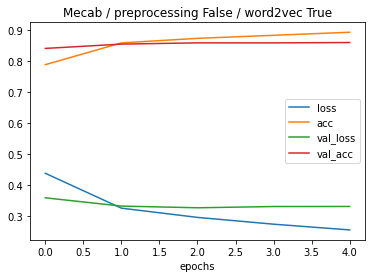

384/384 [==============================] - 8s 21ms/step - loss: 0.3313 - accuracy: 0.8582
테스트셋 accuracy : 85.82%
테스트셋 loss : 0.33126357197761536


In [34]:
add = False # 추가 전처리 여부
vectorization_type = 0 # 벡터화 기법 선택
word2vec = True # word2vec 전이학습 여부

ProjectPipelines(add, vectorization_type, word2vec, tr_path_to_file, te_path_to_file)

### 3.1 전처리 전 형태소 분석기 (Mecab)

In [ ]:
add = False # 추가 전처리 여부
vectorization_type = 0 # 벡터화 기법 선택
word2vec = False # word2vec 전이학습 여부

ProjectPipelines(add, vectorization_type, word2vec, tr_path_to_file, te_path_to_file)

### 3.2 전처리 후 형태소 분석기 (Mecab)

In [126]:
# 추가 전처리 여부
add = True
# 벡터화 기법 선택
vectorization_type = 0

# 훈련셋에 데이터 파이프라인 적용
train02 = DataPipeline(tr_path_to_file, "train")
non_pre_train02 = train02.preprocessing(add = add)
vector_train02, idx_word_train02, word_idx_train02 = train02.vectorization(vectorization_type, vocab_size)
tf_train02, tf_val02 = train02.tensorflow_dataset(batch_size, split = True)

# 테스트셋 불러오기
test02 = DataPipeline(te_path_to_file, "test")
non_pre_test02 = test02.preprocessing(add = add)

# 훈련셋에서 만들어진 인덱스를 테스트셋에 적용
tqdm.pandas()
token_corpus_test02 = non_pre_test02["document"].progress_apply(lambda x: mecab.morphs(x))
idx_corpus_test02 = tokenization(token_corpus_test02, word_idx_train02)

# 패딩
max_length_test02 = max(non_pre_train02["len"])
padd_tokens_test02 = pad_sequences(idx_corpus_test02, padding='post', maxlen = max_length_test02, value = 0)

# 테스트셋을 텐서플로우 데이터셋으로 변환
x_test02 = padd_tokens_test02
y_test02 = non_pre_test02["label"].to_numpy().reshape(-1,1)
buffer_size_test02 = len(non_pre_test02)
tf_test02 = tensorflow_dataset(x_test02, y_test02, buffer_size_test02, batch_size)

100%|██████████| 39109/39109 [00:00<00:00, 211532.01it/s]


Epoch 1/5
731/731 [==============================] - 31s 37ms/step - loss: 0.4567 - accuracy: 0.7695 - val_loss: 0.3558 - val_accuracy: 0.8414
Epoch 2/5
731/731 [==============================] - 26s 35ms/step - loss: 0.3292 - accuracy: 0.8536 - val_loss: 0.3426 - val_accuracy: 0.8467
Epoch 3/5
731/731 [==============================] - 26s 35ms/step - loss: 0.2829 - accuracy: 0.8758 - val_loss: 0.3391 - val_accuracy: 0.8533
Epoch 4/5
731/731 [==============================] - 26s 35ms/step - loss: 0.2550 - accuracy: 0.8904 - val_loss: 0.3492 - val_accuracy: 0.8505


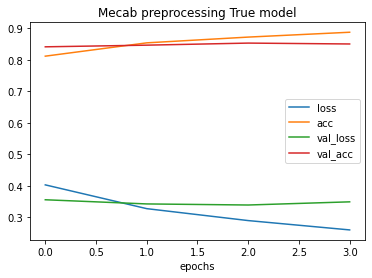

305/305 [==============================] - 4s 11ms/step - loss: 0.3555 - accuracy: 0.8463
테스트셋 accuracy : 84.63000000000001%
테스트셋 loss : 0.3554813861846924


In [127]:
# 서브클래스 모델 선언
model = NSMC_model(vocab_size, embedding_size, hidden_size)

# 모델 컴파일
model.compile(optimizer="adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

# 모델 학습 시작
train_buffer_size02 = int(len(vector_train02) * 0.8)
val_buffer_size02 = int(len(vector_train02) * 0.2)
history = model.fit(tf_train02, 
                    steps_per_epoch = train_buffer_size02 // batch_size,
                    validation_data = tf_val02,
                    validation_steps = val_buffer_size02 // batch_size,
                    epochs = epochs,
                    callbacks = [lr_reduce])

# 모델 학습 추이 시각화
if vectorization_type == 0:
    title = f"Mecab preprocessing {add} model"
elif vectorization_type == 1:
    title = f"Unigram preprocessing {add} model"
else:
    title = f"BPE preprocessing {add} model"
show_performance(history, title)

# 테스트셋으로 모델 검증
test_loss02, test_acc02 = model.evaluate(tf_test02, steps = buffer_size_test02 // batch_size)
print(f"테스트셋 accuracy : {round(test_acc02, 4) * 100}%")
print(f"테스트셋 loss : {test_loss02}")

### 3.3 전처리 후 형태소 분석기 + 사전 학습된 임베딩 벡터 (전이학습)

In [128]:
# 추가 전처리 여부
add = True
# 벡터화 기법 선택
vectorization_type = 0

# 훈련셋에 데이터 파이프라인 적용
train03 = DataPipeline(tr_path_to_file, "train")
non_pre_train03 = train03.preprocessing(add = add)
vector_train03, idx_word_train03, word_idx_train03 = train03.vectorization(vectorization_type, vocab_size)
tf_train03, tf_val03 = train03.tensorflow_dataset(batch_size, split = True)

# 테스트셋 불러오기
test03 = DataPipeline(te_path_to_file, "test")
non_pre_test03 = test03.preprocessing(add = add)

# 훈련셋에서 만들어진 인덱스를 테스트셋에 적용
tqdm.pandas()
token_corpus_test03 = non_pre_test03["document"].progress_apply(lambda x: mecab.morphs(x))
idx_corpus_test03 = tokenization(token_corpus_test03, word_idx_train03)

# 패딩
max_length_test03 = max(non_pre_train03["len"])
padd_tokens_test03 = pad_sequences(idx_corpus_test03, padding='post', maxlen = max_length_test03, value = 0)

# 테스트셋을 텐서플로우 데이터셋으로 변환
x_test03 = padd_tokens_test03
y_test03 = non_pre_test03["label"].to_numpy().reshape(-1,1)
buffer_size_test03 = len(non_pre_test03)
tf_test03 = tensorflow_dataset(x_test03, y_test03, buffer_size_test03, batch_size)

100%|██████████| 39109/39109 [00:00<00:00, 205701.52it/s]


In [129]:
word2vec_path = './model/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

embedding_matrix = np.random.rand(vocab_size, embedding_size)
count = 0
# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(2,vocab_size):
    if idx_word_test03[i] in word2vec:
        embedding_matrix[i] = word2vec[idx_word_test03[i]]
        count += 1
print(f"사전 학습에 사용 가능했던 단어 벡터 갯수 : {count}")

사전 학습에 사용 가능했던 단어 벡터 갯수 : 3361


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


Epoch 1/5
731/731 [==============================] - 31s 37ms/step - loss: 0.5529 - accuracy: 0.6900 - val_loss: 0.3819 - val_accuracy: 0.8236
Epoch 2/5
731/731 [==============================] - 26s 36ms/step - loss: 0.3541 - accuracy: 0.8418 - val_loss: 0.3560 - val_accuracy: 0.8414
Epoch 3/5
731/731 [==============================] - 27s 37ms/step - loss: 0.3116 - accuracy: 0.8648 - val_loss: 0.3534 - val_accuracy: 0.8427
Epoch 4/5
731/731 [==============================] - 26s 36ms/step - loss: 0.2889 - accuracy: 0.8748 - val_loss: 0.3497 - val_accuracy: 0.8476
Epoch 5/5
731/731 [==============================] - 26s 35ms/step - loss: 0.2666 - accuracy: 0.8865 - val_loss: 0.3549 - val_accuracy: 0.8468


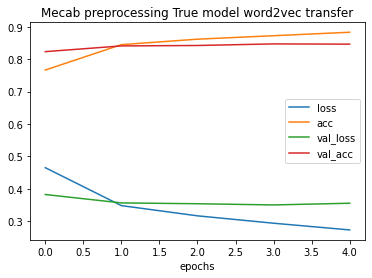

305/305 [==============================] - 4s 11ms/step - loss: 0.3607 - accuracy: 0.8461
테스트셋 accuracy : 84.61%
테스트셋 loss : 0.3607354462146759


In [130]:
# 서브클래스 모델 선언
model = NSMC_word2vec_model(vocab_size, embedding_size, hidden_size, embedding_matrix)

# 모델 컴파일
model.compile(optimizer="adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

# 모델 학습 시작
train_buffer_size03 = int(len(vector_train03) * 0.8)
val_buffer_size03 = int(len(vector_train03) * 0.2)
history = model.fit(tf_train03, 
                    steps_per_epoch = train_buffer_size03 // batch_size,
                    validation_data = tf_val03,
                    validation_steps = val_buffer_size03 // batch_size,
                    epochs = epochs,
                    callbacks = [lr_reduce])

# 모델 학습 추이 시각화
if vectorization_type == 0:
    title = f"Mecab preprocessing {add} model word2vec transfer"
elif vectorization_type == 1:
    title = f"Unigram preprocessing {add} model"
else:
    title = f"BPE preprocessing {add} model"
show_performance(history, title)

# 테스트셋으로 모델 검증
test_loss03, test_acc03 = model.evaluate(tf_test03, steps = buffer_size_test03 // batch_size)
print(f"테스트셋 accuracy : {round(test_acc03, 4) * 100}%")
print(f"테스트셋 loss : {test_loss03}")

### 3.4 전처리 전 SentencePiece (uni-gram)

In [141]:
# 추가 전처리 여부
add = False
# 벡터화 기법 선택
vectorization_type = 1

# 훈련셋에 데이터 파이프라인 적용
train04 = DataPipeline(tr_path_to_file, "train")
non_pre_train04 = train04.preprocessing(add = add)
vector_train04, spm04 = train04.vectorization(vectorization_type, vocab_size)
tf_train04, tf_val04 = train04.tensorflow_dataset(batch_size, split = True)

# 테스트셋 불러오기
test04 = DataPipeline(te_path_to_file, "test")
non_pre_test04 = test04.preprocessing(add = add)

# 훈련셋에서 만들어진 인덱스를 테스트셋에 적용
tqdm.pandas()
token_corpus_test04 = non_pre_test04["document"].progress_apply(lambda x : spm04.EncodeAsIds(str(x)))
max_length_test04 = max(non_pre_train04["len"])
padd_tokens_test04 = pad_sequences(token_corpus_test04, maxlen = max_length_test04, 
                                   padding = "post", value = 0)

# 테스트셋을 텐서플로우 데이터셋으로 변환
x_test04 = padd_tokens_test04
y_test04 = non_pre_test04["label"].to_numpy().reshape(-1,1)
buffer_size_test04 = len(non_pre_test04)
tf_test04 = tensorflow_dataset(x_test04, y_test04, buffer_size_test04, batch_size)

100%|██████████| 49157/49157 [00:01<00:00, 43149.15it/s]


Epoch 1/5
913/913 [==============================] - 63s 65ms/step - loss: 0.4701 - accuracy: 0.7529 - val_loss: 0.3701 - val_accuracy: 0.8361
Epoch 2/5
913/913 [==============================] - 58s 64ms/step - loss: 0.3274 - accuracy: 0.8556 - val_loss: 0.3746 - val_accuracy: 0.8420


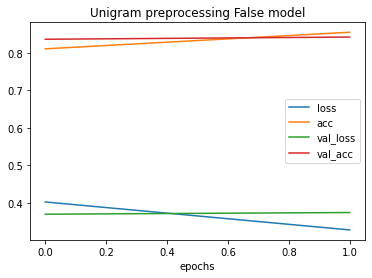

384/384 [==============================] - 8s 21ms/step - loss: 0.3823 - accuracy: 0.8381
테스트셋 accuracy : 83.81%
테스트셋 loss : 0.38232171535491943


In [142]:
# 서브클래스 모델 선언
model = NSMC_model(vocab_size, embedding_size, hidden_size)

# 모델 컴파일
model.compile(optimizer="adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

# 모델 학습 시작
train_buffer_size04 = int(len(vector_train04) * 0.8)
val_buffer_size04 = int(len(vector_train04) * 0.2)
history = model.fit(tf_train04, 
                    steps_per_epoch = train_buffer_size04 // batch_size,
                    validation_data = tf_val04,
                    validation_steps = val_buffer_size04 // batch_size,
                    epochs = epochs,
                    callbacks = [lr_reduce])

# 모델 학습 추이 시각화
if vectorization_type == 0:
    title = f"Mecab preprocessing {add} model word2vec transfer"
elif vectorization_type == 1:
    title = f"Unigram preprocessing {add} model"
else:
    title = f"BPE preprocessing {add} model"
show_performance(history, title)

# 테스트셋으로 모델 검증
test_loss04, test_acc04 = model.evaluate(tf_test04, steps = buffer_size_test04 // batch_size)
print(f"테스트셋 accuracy : {round(test_acc04, 4) * 100}%")
print(f"테스트셋 loss : {test_loss04}")

### 3.5 전처리 전 SentencePiece (byte-pair-enocding)

In [138]:
# 추가 전처리 여부
add = False
# 벡터화 기법 선택
vectorization_type = 2

# 훈련셋에 데이터 파이프라인 적용
train05 = DataPipeline(tr_path_to_file, "train")
non_pre_train05 = train05.preprocessing(add = add)
vector_train05, spm05 = train05.vectorization(vectorization_type, vocab_size)
tf_train05, tf_val05 = train05.tensorflow_dataset(batch_size, split = True)

# 테스트셋 불러오기
test05 = DataPipeline(te_path_to_file, "test")
non_pre_test05 = test05.preprocessing(add = add)

# 훈련셋에서 만들어진 인덱스를 테스트셋에 적용
tqdm.pandas()
token_corpus_test05 = non_pre_test05["document"].progress_apply(lambda x : spm05.EncodeAsIds(str(x)))
max_length_test05 = max(non_pre_train05["len"])
padd_tokens_test05 = pad_sequences(token_corpus_test05, maxlen = max_length_test05, 
                                   padding = "post", value = 0)

# 테스트셋을 텐서플로우 데이터셋으로 변환
x_test05 = padd_tokens_test05
y_test05 = non_pre_test05["label"].to_numpy().reshape(-1,1)
buffer_size_test05 = len(non_pre_test05)
tf_test05 = tensorflow_dataset(x_test05, y_test05, buffer_size_test05, batch_size)

100%|██████████| 49157/49157 [00:01<00:00, 28463.64it/s]


Epoch 1/5
913/913 [==============================] - 62s 64ms/step - loss: 0.5871 - accuracy: 0.6452 - val_loss: 0.4162 - val_accuracy: 0.8108
Epoch 2/5
913/913 [==============================] - 58s 63ms/step - loss: 0.3482 - accuracy: 0.8465 - val_loss: 0.4007 - val_accuracy: 0.8199
Epoch 3/5
913/913 [==============================] - 58s 63ms/step - loss: 0.3091 - accuracy: 0.8666 - val_loss: 0.3583 - val_accuracy: 0.8450
Epoch 4/5
913/913 [==============================] - 58s 63ms/step - loss: 0.2840 - accuracy: 0.8784 - val_loss: 0.3649 - val_accuracy: 0.8417


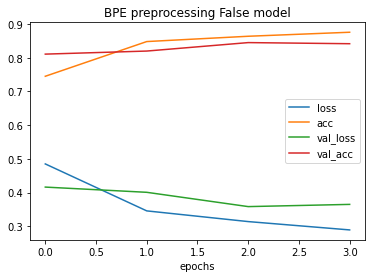

384/384 [==============================] - 8s 21ms/step - loss: 0.3687 - accuracy: 0.8401
테스트셋 accuracy : 84.00999999999999%
테스트셋 loss : 0.3686870038509369


In [139]:
# 서브클래스 모델 선언
model = NSMC_model(vocab_size, embedding_size, hidden_size)

# 모델 컴파일
model.compile(optimizer="adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

# 모델 학습 시작
train_buffer_size05 = int(len(vector_train05) * 0.8)
val_buffer_size05 = int(len(vector_train05) * 0.2)
history = model.fit(tf_train05, 
                    steps_per_epoch = train_buffer_size05 // batch_size,
                    validation_data = tf_val05,
                    validation_steps = val_buffer_size05 // batch_size,
                    epochs = epochs,
                    callbacks = [lr_reduce])

# 모델 학습 추이 시각화
if vectorization_type == 0:
    title = f"Mecab preprocessing {add} model word2vec transfer"
elif vectorization_type == 1:
    title = f"Unigram preprocessing {add} model"
else:
    title = f"BPE preprocessing {add} model"
show_performance(history, title)

# 테스트셋으로 모델 검증
test_loss05, test_acc05 = model.evaluate(tf_test05, steps = buffer_size_test05 // batch_size)
print(f"테스트셋 accuracy : {round(test_acc05, 4) * 100}%")
print(f"테스트셋 loss : {test_loss05}")

### 3.6 전처리 후 SentencePiece (uni-gram)

In [140]:
# 추가 전처리 여부
add = True
# 벡터화 기법 선택
vectorization_type = 1

# 훈련셋에 데이터 파이프라인 적용
train06 = DataPipeline(tr_path_to_file, "train")
non_pre_train06 = train06.preprocessing(add = add)
vector_train06, spm06 = train06.vectorization(vectorization_type, vocab_size)
tf_train06, tf_val06 = train06.tensorflow_dataset(batch_size, split = True)

# 테스트셋 불러오기
test06 = DataPipeline(te_path_to_file, "test")
non_pre_test06 = test06.preprocessing(add = add)

# 훈련셋에서 만들어진 인덱스를 테스트셋에 적용
tqdm.pandas()
token_corpus_test06 = non_pre_test06["document"].progress_apply(lambda x : spm06.EncodeAsIds(str(x)))
max_length_test06 = max(non_pre_train06["len"])
padd_tokens_test06 = pad_sequences(token_corpus_test06, maxlen = max_length_test06, 
                                   padding = "post", value = 0)

# 테스트셋을 텐서플로우 데이터셋으로 변환
x_test06 = padd_tokens_test06
y_test06 = non_pre_test06["label"].to_numpy().reshape(-1,1)
buffer_size_test06 = len(non_pre_test06)
tf_test06 = tensorflow_dataset(x_test06, y_test06, buffer_size_test06, batch_size)

100%|██████████| 39109/39109 [00:00<00:00, 51728.90it/s]


In [ ]:
# 서브클래스 모델 선언
model = NSMC_model(vocab_size, embedding_size, hidden_size)

# 모델 컴파일
model.compile(optimizer="adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

# 모델 학습 시작
train_buffer_size06 = int(len(vector_train06) * 0.8)
val_buffer_size06 = int(len(vector_train06) * 0.2)
history = model.fit(tf_train06, 
                    steps_per_epoch = train_buffer_size06 // batch_size,
                    validation_data = tf_val06,
                    validation_steps = val_buffer_size06 // batch_size,
                    epochs = epochs,
                    callbacks = [lr_reduce])

# 모델 학습 추이 시각화
if vectorization_type == 0:
    title = f"Mecab preprocessing {add} model"
elif vectorization_type == 1:
    title = f"Unigram preprocessing {add} model"
else:
    title = f"BPE preprocessing {add} model"
show_performance(history, title)

# 테스트셋으로 모델 검증
test_loss06, test_acc06 = model.evaluate(tf_test06, steps = buffer_size_test06 // batch_size)
print(f"테스트셋 accuracy : {round(test_acc06, 4) * 100}%")
print(f"테스트셋 loss : {test_loss06}")

### 3.7 전처리 후 SentencePiece (byte-pair-enocding)

In [49]:
# 추가 전처리 여부
add = True
# 벡터화 기법 선택
vectorization_type = 2

# 훈련셋에 데이터 파이프라인 적용
train07 = DataPipeline(tr_path_to_file, "train")
non_pre_train07 = train07.preprocessing(add = add)
vector_train07, spm07 = train07.vectorization(vectorization_type, vocab_size)
tf_train07, tf_val07 = train07.tensorflow_dataset(batch_size, split = True)

# 테스트셋 불러오기
test07 = DataPipeline(te_path_to_file, "test")
non_pre_test07 = test07.preprocessing(add = add)

# 훈련셋에서 만들어진 인덱스를 테스트셋에 적용
tqdm.pandas()
token_corpus_test07 = non_pre_test07["document"].progress_apply(lambda x : spm07.EncodeAsIds(str(x)))
max_length_test07 = max(non_pre_train07["len"])
padd_tokens_test07 = pad_sequences(token_corpus_test07, maxlen = max_length_test07, 
                                   padding = "post", value = 0)

# 테스트셋을 텐서플로우 데이터셋으로 변환
x_test07 = padd_tokens_test07
y_test07 = non_pre_test07["label"].to_numpy().reshape(-1,1)
buffer_size_test07 = len(non_pre_test07)
tf_test07 = tensorflow_dataset(x_test07, y_test07, buffer_size_test07, batch_size)

In [ ]:
# 서브클래스 모델 선언
model = NSMC_model(vocab_size, embedding_size, hidden_size)

# 모델 컴파일
model.compile(optimizer="adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

# 모델 학습 시작
train_buffer_size07 = int(len(vector_train07) * 0.8)
val_buffer_size07 = int(len(vector_train07) * 0.2)
history = model.fit(tf_train07, 
                    steps_per_epoch = train_buffer_size07 // batch_size,
                    validation_data = tf_val07,
                    validation_steps = val_buffer_size07 // batch_size,
                    epochs = epochs,
                    callbacks = [lr_reduce])

# 모델 학습 추이 시각화
if vectorization_type == 0:
    title = f"Mecab preprocessing {add} model"
elif vectorization_type == 1:
    title = f"Unigram preprocessing {add} model"
else:
    title = f"BPE preprocessing {add} model"
show_performance(history, title)

# 테스트셋으로 모델 검증
test_loss07, test_acc07 = model.evaluate(tf_test07, steps = buffer_size_test07 // batch_size)
print(f"테스트셋 accuracy : {round(test_acc07, 4) * 100}%")
print(f"테스트셋 loss : {test_loss07}")

### 3.8 전처리 후 형태소 분석기 (Mecab) + SetencePiece (uni-gram)

In [151]:
# 데이터 블러오고 추가 전처리까지 진행
add = True
train08 = DataPipeline(tr_path_to_file, "train")
pre_train08 = train08.preprocessing(add = add)
# Mecab으로 형태소 단위로 나눈 뒤 다시 str으로 합쳐줌
tqdm.pandas()
pre_train08["document"] = pre_train08["document"].progress_apply(lambda x: " ".join(mecab.morphs(x)))

# spm 모델 unigram으로 생성
model_type = "unigram"
spm08 = SentencePiece(model_type, pre_train08, 
                      vocab_size, add,
                      temp_file = f"./model/02_SentencePiece/{model_type}_{vocab_size}_pre{add}_mecab_train.tmp",
                      train_test = "train")

# 추가 전처리까지 된 코퍼스 unigram 타입으로 벡터화
max_len08 = max(pre_train08["len"])
id_document08 = pre_train08["document"].apply(lambda x : spm08.EncodeAsIds(str(x)))
padd_token08 = pad_sequences(id_document08, maxlen = max_len, padding = "post")

# 텐서플로우 데이터셋으로 변환
x_data08 = padd_token08
y_data08 = pre_train08["label"].to_numpy().reshape(-1, 1)
x_train08, x_val08, y_train08, y_val08 = train_test_split(x_data08, y_data08, 
                                                          test_size = 0.2,
                                                          random_state = 44)
tr_buffer08 = len(x_train08)
tf_train08 = tensorflow_dataset(x_train08, y_train08, tr_buffer08, batch_size)
val_buffer08 = len(x_val08)
tf_val08 = tensorflow_dataset(x_val08, y_val08, val_buffer08, batch_size)

# 테스트셋 불러오기
test08 = DataPipeline(te_path_to_file, "test")
pre_test08 = test08.preprocessing(add = add)

# 훈련셋에서 만들어진 인덱스를 테스트셋에 적용
tqdm.pandas()
token_corpus_test08 = pre_test08["document"].progress_apply(lambda x : spm08.EncodeAsIds(str(x)))
max_length_test08 = max(pre_train08["len"])
padd_tokens_test08 = pad_sequences(token_corpus_test08, maxlen = max_length_test08, 
                                   padding = "post", value = 0)

# 테스트셋을 텐서플로우 데이터셋으로 변환
x_test08 = padd_tokens_test08
y_test08 = pre_test08["label"].to_numpy().reshape(-1,1)
buffer_size_test08 = len(pre_test08)
tf_test08 = tensorflow_dataset(x_test08, y_test08, buffer_size_test08, batch_size)

100%|██████████| 39109/39109 [00:00<00:00, 47344.23it/s]


Epoch 1/5
731/731 [==============================] - 30s 36ms/step - loss: 0.4793 - accuracy: 0.7478 - val_loss: 0.3675 - val_accuracy: 0.8368
Epoch 2/5
731/731 [==============================] - 26s 35ms/step - loss: 0.3308 - accuracy: 0.8535 - val_loss: 0.3460 - val_accuracy: 0.8447
Epoch 3/5
731/731 [==============================] - 26s 35ms/step - loss: 0.2934 - accuracy: 0.8726 - val_loss: 0.3432 - val_accuracy: 0.8487
Epoch 4/5
731/731 [==============================] - 26s 35ms/step - loss: 0.2599 - accuracy: 0.8881 - val_loss: 0.3877 - val_accuracy: 0.8455
Epoch 5/5
731/731 [==============================] - 26s 35ms/step - loss: 0.2172 - accuracy: 0.9110 - val_loss: 0.3877 - val_accuracy: 0.8486


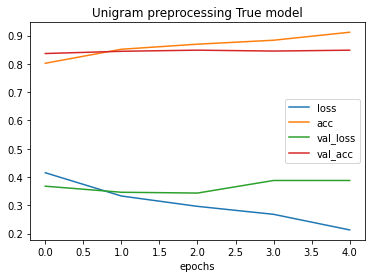

305/305 [==============================] - 4s 11ms/step - loss: 0.5416 - accuracy: 0.7922
테스트셋 accuracy : 79.22%
테스트셋 loss : 0.5416272878646851


In [152]:
# 서브클래스 모델 선언
model = NSMC_model(vocab_size, embedding_size, hidden_size)

# 모델 컴파일
model.compile(optimizer="adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

# 모델 학습 시작
train_buffer_size08 = int(len(pre_train08) * 0.8)
val_buffer_size08 = int(len(pre_train08) * 0.2)
history = model.fit(tf_train08, 
                    steps_per_epoch = train_buffer_size08 // batch_size,
                    validation_data = tf_val08,
                    validation_steps = val_buffer_size08 // batch_size,
                    epochs = epochs,
                    callbacks = [lr_reduce])

# 모델 학습 추이 시각화
if vectorization_type == 0:
    title = f"Mecab preprocessing {add} model word2vec transfer"
elif vectorization_type == 1:
    title = f"Unigram preprocessing {add} model"
else:
    title = f"BPE preprocessing {add} model"
show_performance(history, title)

# 테스트셋으로 모델 검증
test_loss08, test_acc08 = model.evaluate(tf_test08, steps = buffer_size_test08 // batch_size)
print(f"테스트셋 accuracy : {round(test_acc08, 4) * 100}%")
print(f"테스트셋 loss : {test_loss08}")

### 3.9 전처리 후 형태소 분석기 (Mecab) + SetencePiece (byte-pair-enocding)

In [153]:
# 데이터 블러오고 추가 전처리까지 진행
add = True
train09 = DataPipeline(tr_path_to_file, "train")
pre_train09 = train09.preprocessing(add = add)
# Mecab으로 형태소 단위로 나눈 뒤 다시 str으로 합쳐줌
mecab = Mecab()
tqdm.pandas()
pre_train09["document"] = pre_train09["document"].progress_apply(lambda x: " ".join(mecab.morphs(x)))

# spm 모델 unigram으로 생성
model_type = "bpe"
spm09 = SentencePiece(model_type, pre_train09, 
                      vocab_size, add,
                      temp_file = f"./model/02_SentencePiece/{model_type}_{vocab_size}_pre{add}_mecab_train.tmp",
                      train_test = "train")

# 추가 전처리까지 된 코퍼스 unigram 타입으로 벡터화
max_len09 = max(pre_train09["len"])
id_document09 = pre_train09["document"].apply(lambda x : spm09.EncodeAsIds(str(x)))
padd_token09 = pad_sequences(id_document09, maxlen = max_len, padding = "post")

# 텐서플로우 데이터셋으로 변환
x_data09 = padd_token09
y_data09 = pre_train09["label"].to_numpy().reshape(-1, 1)
x_train09, x_val09, y_train09, y_val09 = train_test_split(x_data09, y_data09, 
                                                          test_size = 0.2,
                                                          random_state = 44)
tr_buffer09 = len(x_train09)
tf_train09 = tensorflow_dataset(x_train09, y_train09, tr_buffer09, batch_size)
val_buffer09 = len(x_val09)
tf_val09 = tensorflow_dataset(x_val09, y_val09, val_buffer09, batch_size)

# 테스트셋 불러오기
test09 = DataPipeline(te_path_to_file, "test")
pre_test09 = test09.preprocessing(add = add)

# 훈련셋에서 만들어진 인덱스를 테스트셋에 적용
tqdm.pandas()
token_corpus_test09 = pre_test09["document"].progress_apply(lambda x : spm09.EncodeAsIds(str(x)))
max_length_test09 = max(pre_train09["len"])
padd_tokens_test09 = pad_sequences(token_corpus_test09, maxlen = max_length_test09, 
                                   padding = "post", value = 0)

# 테스트셋을 텐서플로우 데이터셋으로 변환
x_test09 = padd_tokens_test09
y_test09 = pre_test09["label"].to_numpy().reshape(-1,1)
buffer_size_test09 = len(pre_test09)
tf_test09 = tensorflow_dataset(x_test09, y_test09, buffer_size_test09, batch_size)

100%|██████████| 39109/39109 [00:00<00:00, 39585.56it/s]


Epoch 1/5
731/731 [==============================] - 30s 36ms/step - loss: 0.4697 - accuracy: 0.7614 - val_loss: 0.3749 - val_accuracy: 0.8325
Epoch 2/5
731/731 [==============================] - 26s 35ms/step - loss: 0.3349 - accuracy: 0.8505 - val_loss: 0.3446 - val_accuracy: 0.8469
Epoch 3/5
731/731 [==============================] - 27s 37ms/step - loss: 0.2920 - accuracy: 0.8722 - val_loss: 0.3465 - val_accuracy: 0.8518
Epoch 4/5
731/731 [==============================] - 28s 38ms/step - loss: 0.2429 - accuracy: 0.8981 - val_loss: 0.3600 - val_accuracy: 0.8535
Epoch 5/5
731/731 [==============================] - 28s 38ms/step - loss: 0.2269 - accuracy: 0.9052 - val_loss: 0.3583 - val_accuracy: 0.8535


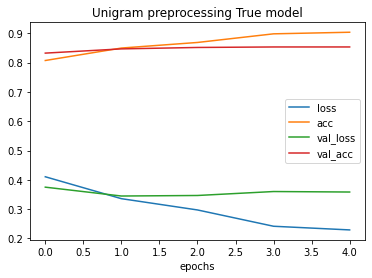

305/305 [==============================] - 4s 12ms/step - loss: 0.4813 - accuracy: 0.7947
테스트셋 accuracy : 79.47%
테스트셋 loss : 0.4813026189804077


In [154]:
# 서브클래스 모델 선언
model = NSMC_model(vocab_size, embedding_size, hidden_size)

# 모델 컴파일
model.compile(optimizer="adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

# 모델 학습 시작
train_buffer_size09 = int(len(pre_train09) * 0.8)
val_buffer_size09 = int(len(pre_train09) * 0.2)
history = model.fit(tf_train09, 
                    steps_per_epoch = train_buffer_size09 // batch_size,
                    validation_data = tf_val09,
                    validation_steps = val_buffer_size09 // batch_size,
                    epochs = epochs,
                    callbacks = [lr_reduce])

# 모델 학습 추이 시각화
if vectorization_type == 0:
    title = f"Mecab preprocessing {add} model word2vec transfer"
elif vectorization_type == 1:
    title = f"Unigram preprocessing {add} model"
else:
    title = f"BPE preprocessing {add} model"
show_performance(history, title)

# 테스트셋으로 모델 검증
test_loss09, test_acc09 = model.evaluate(tf_test09, steps = buffer_size_test09 // batch_size)
print(f"테스트셋 accuracy : {round(test_acc09, 4) * 100}%")
print(f"테스트셋 loss : {test_loss09}")

### 3.10 전처리 전 형태소 분석기 (Mecab) + SetencePiece (uni-gram)

In [155]:
# 데이터 블러오고 추가 전처리까지 진행
add = False
train10 = DataPipeline(tr_path_to_file, "train")
pre_train10 = train10.preprocessing(add = add)
# Mecab으로 형태소 단위로 나눈 뒤 다시 str으로 합쳐줌
mecab = Mecab()
tqdm.pandas()
pre_train10["document"] = pre_train10["document"].progress_apply(lambda x: " ".join(mecab.morphs(x)))

# spm 모델 unigram으로 생성
model_type = "unigram"
spm10 = SentencePiece(model_type, pre_train10, 
                      vocab_size, add,
                      temp_file = f"./model/02_SentencePiece/{model_type}_{vocab_size}_pre{add}_mecab_train.tmp",
                      train_test = "train")

# 추가 전처리까지 된 코퍼스 unigram 타입으로 벡터화
max_len10 = max(pre_train10["len"])
id_document10 = pre_train10["document"].apply(lambda x : spm10.EncodeAsIds(str(x)))
padd_token10 = pad_sequences(id_document10, maxlen = max_len, padding = "post")

# 텐서플로우 데이터셋으로 변환
x_data10 = padd_token10
y_data10 = pre_train10["label"].to_numpy().reshape(-1, 1)
x_train10, x_val10, y_train10, y_val10 = train_test_split(x_data10, y_data10, 
                                                          test_size = 0.2,
                                                          random_state = 44)
tr_buffer10 = len(x_train10)
tf_train10 = tensorflow_dataset(x_train10, y_train10, tr_buffer10, batch_size)
val_buffer10 = len(x_val10)
tf_val10 = tensorflow_dataset(x_val10, y_val10, val_buffer10, batch_size)

# 테스트셋 불러오기
test10 = DataPipeline(te_path_to_file, "test")
pre_test10 = test10.preprocessing(add = add)

# 훈련셋에서 만들어진 인덱스를 테스트셋에 적용
tqdm.pandas()
token_corpus_test10 = pre_test10["document"].progress_apply(lambda x : spm10.EncodeAsIds(str(x)))
max_length_test10 = max(pre_train10["len"])
padd_tokens_test10 = pad_sequences(token_corpus_test10, maxlen = max_length_test10, 
                                   padding = "post", value = 0)

# 테스트셋을 텐서플로우 데이터셋으로 변환
x_test10 = padd_tokens_test10
y_test10 = pre_test10["label"].to_numpy().reshape(-1,1)
buffer_size_test10 = len(pre_test10)
tf_test10 = tensorflow_dataset(x_test10, y_test10, buffer_size_test10, batch_size)

100%|██████████| 49157/49157 [00:01<00:00, 34497.44it/s]


Epoch 1/5
913/913 [==============================] - 39s 37ms/step - loss: 0.4495 - accuracy: 0.7743 - val_loss: 0.3565 - val_accuracy: 0.8446
Epoch 2/5
913/913 [==============================] - 32s 35ms/step - loss: 0.3203 - accuracy: 0.8605 - val_loss: 0.3217 - val_accuracy: 0.8588
Epoch 3/5
913/913 [==============================] - 32s 36ms/step - loss: 0.2711 - accuracy: 0.8845 - val_loss: 0.3301 - val_accuracy: 0.8604
Epoch 4/5
913/913 [==============================] - 32s 35ms/step - loss: 0.2298 - accuracy: 0.9034 - val_loss: 0.3310 - val_accuracy: 0.8607
Epoch 5/5
913/913 [==============================] - 32s 35ms/step - loss: 0.2156 - accuracy: 0.9112 - val_loss: 0.3378 - val_accuracy: 0.8607


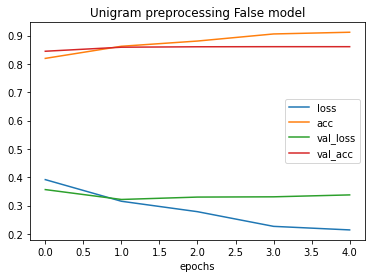

384/384 [==============================] - 9s 21ms/step - loss: 0.4894 - accuracy: 0.8133
테스트셋 accuracy : 81.33%
테스트셋 loss : 0.4893680512905121


In [156]:
# 서브클래스 모델 선언
model = NSMC_model(vocab_size, embedding_size, hidden_size)

# 모델 컴파일
model.compile(optimizer="adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

# 모델 학습 시작
train_buffer_size10 = int(len(pre_train10) * 0.8)
val_buffer_size10 = int(len(pre_train10) * 0.2)
history = model.fit(tf_train10, 
                    steps_per_epoch = train_buffer_size10 // batch_size,
                    validation_data = tf_val10,
                    validation_steps = val_buffer_size10 // batch_size,
                    epochs = epochs,
                    callbacks = [lr_reduce])

# 모델 학습 추이 시각화
if vectorization_type == 0:
    title = f"Mecab preprocessing {add} model word2vec transfer"
elif vectorization_type == 1:
    title = f"Unigram preprocessing {add} model"
else:
    title = f"BPE preprocessing {add} model"
show_performance(history, title)

# 테스트셋으로 모델 검증
test_loss10, test_acc10 = model.evaluate(tf_test10, steps = buffer_size_test10 // batch_size)
print(f"테스트셋 accuracy : {round(test_acc10, 4) * 100}%")
print(f"테스트셋 loss : {test_loss10}")

### 3.11 전처리 전 형태소 분석기 (Mecab) + SetencePiece (byte-pair-enocding)

In [155]:
# 데이터 블러오고 추가 전처리까지 진행
add = False
train10 = DataPipeline(tr_path_to_file, "train")
pre_train10 = train10.preprocessing(add = add)
# Mecab으로 형태소 단위로 나눈 뒤 다시 str으로 합쳐줌
mecab = Mecab()
tqdm.pandas()
pre_train10["document"] = pre_train10["document"].progress_apply(lambda x: " ".join(mecab.morphs(x)))

# spm 모델 unigram으로 생성
model_type = "bpe"
spm10 = SentencePiece(model_type, pre_train10, 
                      vocab_size, add,
                      temp_file = f"./model/02_SentencePiece/{model_type}_{vocab_size}_pre{add}_mecab_train.tmp",
                      train_test = "train")

# 추가 전처리까지 된 코퍼스 unigram 타입으로 벡터화
max_len10 = max(pre_train10["len"])
id_document10 = pre_train10["document"].apply(lambda x : spm10.EncodeAsIds(str(x)))
padd_token10 = pad_sequences(id_document10, maxlen = max_len, padding = "post")

# 텐서플로우 데이터셋으로 변환
x_data10 = padd_token10
y_data10 = pre_train10["label"].to_numpy().reshape(-1, 1)
x_train10, x_val10, y_train10, y_val10 = train_test_split(x_data10, y_data10, 
                                                          test_size = 0.2,
                                                          random_state = 44)
tr_buffer10 = len(x_train10)
tf_train10 = tensorflow_dataset(x_train10, y_train10, tr_buffer10, batch_size)
val_buffer10 = len(x_val10)
tf_val10 = tensorflow_dataset(x_val10, y_val10, val_buffer10, batch_size)

# 테스트셋 불러오기
test10 = DataPipeline(te_path_to_file, "test")
pre_test10 = test10.preprocessing(add = add)

# 훈련셋에서 만들어진 인덱스를 테스트셋에 적용
tqdm.pandas()
token_corpus_test10 = pre_test10["document"].progress_apply(lambda x : spm10.EncodeAsIds(str(x)))
max_length_test10 = max(pre_train10["len"])
padd_tokens_test10 = pad_sequences(token_corpus_test10, maxlen = max_length_test10, 
                                   padding = "post", value = 0)

# 테스트셋을 텐서플로우 데이터셋으로 변환
x_test10 = padd_tokens_test10
y_test10 = pre_test10["label"].to_numpy().reshape(-1,1)
buffer_size_test10 = len(pre_test10)
tf_test10 = tensorflow_dataset(x_test10, y_test10, buffer_size_test10, batch_size)

100%|██████████| 49157/49157 [00:01<00:00, 34497.44it/s]


Epoch 1/5
913/913 [==============================] - 39s 37ms/step - loss: 0.4495 - accuracy: 0.7743 - val_loss: 0.3565 - val_accuracy: 0.8446
Epoch 2/5
913/913 [==============================] - 32s 35ms/step - loss: 0.3203 - accuracy: 0.8605 - val_loss: 0.3217 - val_accuracy: 0.8588
Epoch 3/5
913/913 [==============================] - 32s 36ms/step - loss: 0.2711 - accuracy: 0.8845 - val_loss: 0.3301 - val_accuracy: 0.8604
Epoch 4/5
913/913 [==============================] - 32s 35ms/step - loss: 0.2298 - accuracy: 0.9034 - val_loss: 0.3310 - val_accuracy: 0.8607
Epoch 5/5
913/913 [==============================] - 32s 35ms/step - loss: 0.2156 - accuracy: 0.9112 - val_loss: 0.3378 - val_accuracy: 0.8607


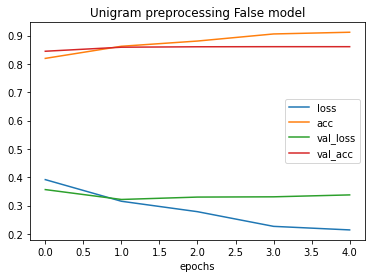

384/384 [==============================] - 9s 21ms/step - loss: 0.4894 - accuracy: 0.8133
테스트셋 accuracy : 81.33%
테스트셋 loss : 0.4893680512905121


In [156]:
# 서브클래스 모델 선언
model = NSMC_model(vocab_size, embedding_size, hidden_size)

# 모델 컴파일
model.compile(optimizer="adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

# 모델 학습 시작
train_buffer_size10 = int(len(pre_train10) * 0.8)
val_buffer_size10 = int(len(pre_train10) * 0.2)
history = model.fit(tf_train10, 
                    steps_per_epoch = train_buffer_size10 // batch_size,
                    validation_data = tf_val10,
                    validation_steps = val_buffer_size10 // batch_size,
                    epochs = epochs,
                    callbacks = [lr_reduce])

# 모델 학습 추이 시각화
if vectorization_type == 0:
    title = f"Mecab preprocessing {add} model word2vec transfer"
elif vectorization_type == 1:
    title = f"Unigram preprocessing {add} model"
else:
    title = f"BPE preprocessing {add} model"
show_performance(history, title)

# 테스트셋으로 모델 검증
test_loss10, test_acc10 = model.evaluate(tf_test10, steps = buffer_size_test10 // batch_size)
print(f"테스트셋 accuracy : {round(test_acc10, 4) * 100}%")
print(f"테스트셋 loss : {test_loss10}")